#Web mining project - Twitter

Kaggle data: https://www.kaggle.com/kazanova/sentiment140

## Must run this

Imports

In [0]:
!pip install PyYAML
!pip install -U PyYAML
import yaml
print("In order to load model, version should be greater than 5")
print("Current version = ",yaml.__version__)

In [0]:
import nltk
import os
import string 
import pandas as pd
import re
import numpy as np
import csv
import io
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import files

# BS4
from bs4 import BeautifulSoup

# NLTK
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords, state_union
from nltk.stem import SnowballStemmer
from nltk.tokenize import WordPunctTokenizer

# Pathlib
from pathlib import Path

# wordcloud
!pip install wordcloud
from wordcloud import WordCloud


from sklearn.feature_extraction.text import CountVectorizer
# print nice df
from tabulate import tabulate

# Collections
import operator 
import json
from collections import Counter, defaultdict

nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('state_union')

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.utils.extmath import density
from sklearn import metrics


from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


# Keras - LSTM
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb


from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.text import Tokenizer

In [0]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, Dropout

from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

Cleanning

In [0]:
www_pattern = r'www.[^ ]+'
users_pattern = r'@[^\s]+'
links_pattern = r'https?://[^ ]+'

combined_patern = r'|'.join((www_pattern,
                             users_pattern,
                             links_pattern))

stop_words = set(stopwords.words('english'))
stop_words.add("rt")
stop_words.add("get")


def tweet_cleaning(text, tokenizer):
    soup = BeautifulSoup(text,'lxml')
    clean_soup = soup.get_text()

    cleaned = re.sub(combined_patern, '', clean_soup)
    remove_latin_tokens = re.sub(r'ï¿½','?',cleaned)
    hashtag_removed = re.sub("[^a-zA-Z]"," ",remove_latin_tokens)

    lower_case = hashtag_removed.lower()

    #----------------------Remove-stopwords-------------------------------------------#
    words = [word for word in tokenizer.tokenize(lower_case) if word not in stop_words]

    return (" ".join(words)).strip()

Data exploration

In [0]:
def class_distribution(data,sentiment_target_value):
  if sentiment_target_value in data['target'].values:
    return data['target'].value_counts()[sentiment_target_value]
  else:
    return 0

In [0]:
# Terms frequency for the different sentiments:

COMMON_TERMS_MAX_SIZE = 20
Terms_Frequency_Per_Sentiment_Dict = dict()

# Count different sentiment values per term
def count_sentiment_per_term(data):
    negative_counter = Counter()
    neutral_counter = Counter()
    positive_counter = Counter()
    for index, row in data.iterrows():
        if row['target'] == 0:
            negative_counter.update(row['text'].split())
        elif  row['target'] == 2:
            neutral_counter.update(row['text'].split())
        elif  row['target'] == 4:
            positive_counter.update(row['text'].split())

    Terms_Frequency_Per_Sentiment_Dict[0] = dict(negative_counter.most_common(COMMON_TERMS_MAX_SIZE))
    Terms_Frequency_Per_Sentiment_Dict[2] = dict(neutral_counter.most_common(COMMON_TERMS_MAX_SIZE))
    Terms_Frequency_Per_Sentiment_Dict[4] = dict(positive_counter.most_common(COMMON_TERMS_MAX_SIZE))


In [0]:
def print_plot_for_terms_distribution(sentiment, input):
    input = dict(sorted(input.items(), key=operator.itemgetter(1), reverse=True)[:15])
    instances_threshold = 10
    dict_input = (dict((k, v) for k, v in input.items() if v >= instances_threshold)) 
    dict_input = {k: v for k, v in sorted(dict_input.items(), key=lambda item: item[1], reverse=True)}
    plt.title("Term Frequency per term in sentiment: " + str(sentiment))
    plt.xlabel('Term')
    plt.ylabel('Term Frequency')
    plt.bar(list(dict_input.keys()), height = dict_input.values(), width= 1, color='b')
    plt.show()


def print_table_by_sentiment(name, value):
    print ('_' * 37)
    sorted_terms = sorted(Terms_Frequency_Per_Sentiment_Dict[value].items(), key=lambda item: item[1] , reverse=True)
    filtered_sorted_terms = pd.DataFrame(sorted_terms, columns=['Term', 'Term frequency']) 
    df_term_sentiment = filtered_sorted_terms[filtered_sorted_terms['Term'].str.len() > 1][:COMMON_TERMS_MAX_SIZE]
  
    print ('Top '+str(COMMON_TERMS_MAX_SIZE)+' terms for sentiment : '+ name)
    print ('_' * 37)
    if df_term_sentiment.empty:
      print("There are no tweets with this sentiment value")
    else:
      print (df_term_sentiment)


def count_sentiments(data, value):
  return sum([1 for i in data if i == value])



def plot_sentiment_pie(sentiment_sizes):
  sizes = sentiment_sizes
  explode = (0, 0, 0.1)
  labels = 'Negative', 'Neutral', 'Positive'
  plt.figure(figsize=(5,5))
  plt.pie(sizes, explode=explode, colors=('deepskyblue','w','springgreen'), labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=60, wedgeprops={'alpha':0.8})
  plt.axis('equal') 
  plt.title('Sentiment tweet distribution')
  plt.show()

In [0]:
#Vectorization for Data Visualization
def get_frequency_df(table):
    #CountVectorizer will convert a collection of text documents to a matrix of token counts
    #Produces a sparse representation of the counts 
    #Initialize
    vector = CountVectorizer()
    #We fit and transform the vector created
    frequency_matrix = vector.fit_transform(table.text)
    #Sum all the frequencies for each word
    sum_frequencies = np.sum(frequency_matrix, axis=0)
    #Now we use squeeze to remove single-dimensional entries from the shape of an array that we got from applying np.asarray to
    #the sum of frequencies.
    frequency = np.squeeze(np.asarray(sum_frequencies))
    #Now we get into a dataframe all the frequencies and the words that they correspond to
    
    d = {'terms': vector.get_feature_names(), 'frequency': frequency}
    frequency_df = pd.DataFrame(data=d)
    
    frequency_df = frequency_df.sort_values('frequency', ascending=False)
    return frequency_df




TOP_NUMBER = 40
def graph(word_frequency):
    labels = word_frequency['terms'][:TOP_NUMBER]
    title = "Term Frequency"
    #Plot the figures
    plt.figure(figsize=(10,5))
    plt.bar(np.arange(TOP_NUMBER), word_frequency['frequency'][:TOP_NUMBER], width = 0.7, 
            color = sns.color_palette("bwr"), alpha=0.5, 
            edgecolor = "black", capsize=8, linewidth=1);
    plt.xticks(np.arange(TOP_NUMBER), labels, rotation=90, size=12);
    plt.xlabel("%d most frequent Terms" % TOP_NUMBER, size=14);
    plt.ylabel("Frequency", size=14);


    plt.title(title, size=18)
    plt.grid(False);
    plt.gca().spines["top"].set_visible(False);
    plt.gca().spines["right"].set_visible(False);
    plt.show() 

## Kaggle Dataset import to data frame

In [0]:
training_file_name = "training.1600000.processed.noemoticon.csv"
columns = ['target','id', 'date', 'flag', 'user', 'text']

df_original = pd.read_csv(training_file_name, names=columns,header = None, encoding='latin1')
print("Total amount of raws is : " +  str(df_original['target'].count()) + '\n')
print("Preview data frame")
df_original.head()

Total amount of raws is : 1600000

Preview data frame


,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


**Count values for each instance of the target: <br>**
0 = negative <br>
2 = neutral <br>
4 = positive <br>

In [0]:
df_original['target'].value_counts()

4    800000
0    800000
Name: target, dtype: int64

**Remove unnecessary data**

In [0]:
df_original.drop(columns = ['id', 'date', 'flag', 'user'],inplace = True)
df_original.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


**Get the length of each string in the dataset**

In [0]:
df_original['text_length'] = [len(words) for words in df_original['text']]
df_original.head(10)

,target,text,text_length
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115
1,0,is upset that he can't update his Facebook by ...,111
2,0,@Kenichan I dived many times for the ball. Man...,89
3,0,my whole body feels itchy and like its on fire,47
4,0,"@nationwideclass no, it's not behaving at all....",111
5,0,@Kwesidei not the whole crew,29
6,0,Need a hug,11
7,0,@LOLTrish hey long time no see! Yes.. Rains a...,99
8,0,@Tatiana_K nope they didn't have it,36
9,0,@twittera que me muera ?,25


**Overall distribution of text length of each text in each tweet**

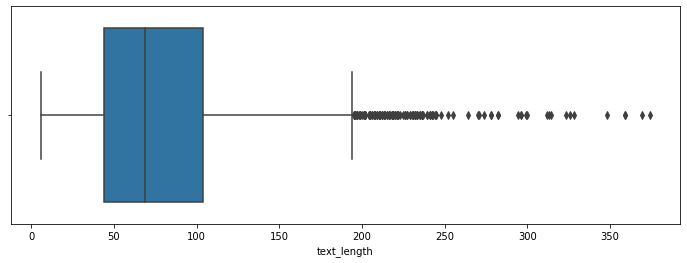

In [0]:
plt.figure(figsize = (12,4))
sns.boxplot(df_original['text_length'])

**In order to test how to clean the data, lets take a look on long tweets**

In [0]:
df_original[df_original['text_length'] > 150].head(10)

,target,text,text_length
1767,0,tks pa 4 &quot;tapauing&quot; croissant tuna k...,152
3434,0,@danielhcwong Taylor 814ce --&gt; #&amp;$(#&am...,157
6894,0,Woke up early this morning to &quot;not all th...,158
13538,0,Took niece &amp; nephew to Blockbuster- rented...,167
16809,0,@SongzYuuup wat is the name of ur mixtape with...,161
17007,0,Tanned and had dinner with my Dad. Now TWO Joh...,160
19818,0,I don't like it when people use the word &quot...,168
20666,0,&quot;Now is no time 2go headlong in2 a diffic...,151
21867,0,i love u bro. thanks for all the memories:sar...,156
23088,0,@jeffpulver sayin' &quot;hi&quot;. Still upset...,152


**--> As we can see there are html tags and @Usernames, so we will clean the data accordingly**


## Text pre-processing

**Remove 'text_length' column and clean the text of each tweet**

In [0]:
df_original.drop(columns=['text_length'])

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


**Clean original tweets and save the file**

In [0]:
word_tokenizer = WordPunctTokenizer()

pre_filtered_clean_tweets =  pd.DataFrame(columns = ['target', 'text']) 
pre_filtered_clean_tweets['text'] = df_original['text'].apply(lambda x:tweet_cleaning(x, word_tokenizer))
pre_filtered_clean_tweets['target'] = df_original['target']
print("Amount of clean tweets before removing short tweets is: " + str(len(pre_filtered_clean_tweets)))
clean_tweets = pre_filtered_clean_tweets[pre_filtered_clean_tweets['text'].str.len() > 2]
print("Amount of clean tweets after removing short tweets is: " + str(len(clean_tweets)))
clean_tweets.to_csv('cleaned_kaggle_dataset.csv')

print("Clean tweets were saved successfully :)")

Amount of clean tweets before removing short tweets is: 1600000
Amount of clean tweets after removing short tweets is: 1589716
Clean tweets were saved successfully :)


** We chose to remove tweets which are shorter than 5 characters because we saw that it does not give us and indication about the sentiment of the tweet and it is more likely to be an unusual case or not a real tweet.

**Load the clean data**

In [0]:
loaded_clean_tweets = pd.read_csv('cleaned_kaggle_dataset.csv',header=1, names=['idx','target','text'], encoding='latin')
print(" Clean tweets were loaded successfully :)")

print("Loaded size = " +  str(len(loaded_clean_tweets)) + ", after removing tweets shorter than 5 characters")

 Clean tweets were loaded successfully :)
Loaded size = 1589715, after removing tweets shorter than 5 characters


**Update cleaned text and preview cleaned data**

In [0]:
tweets_data = loaded_clean_tweets.drop(columns=['idx'])

tweets_data = tweets_data[tweets_data['text'].notna()]
tweets_data.head(10)

,target,text
0,0,upset update facebook texting might cry result...
1,0,dived many times ball managed save rest go bounds
2,0,whole body feels itchy like fire
3,0,behaving mad see
4,0,whole crew
5,0,need hug
6,0,hey long time see yes rains bit bit lol fine t...
7,0,nope
8,0,que muera
9,0,spring break plain city snowing


## Data exploration

In [0]:

# Class Distribution:
sentiment_target = ['negative', 'neutral','positive']

sentiment_dict = {
  "negative": 0,
  "neutral": 2,
  "positive": 4
}

negative_sentiment_value = 0
neutral_sentiment_value = 2
positive_sentiment_value = 4

negative_tweets = class_distribution(tweets_data, sentiment_dict["negative"])
neutral_tweets = class_distribution(tweets_data, sentiment_dict["neutral"])
positive_tweets = class_distribution(tweets_data, sentiment_dict["positive"])

sentiment_tweet_counts = [negative_tweets,neutral_tweets,positive_tweets]

print("Amount of negative tweets: " + str(negative_tweets))
print("Amount of neutral tweets: " + str(neutral_tweets))
print("Amount of positive tweets: " + str(positive_tweets))

Amount of negative tweets: 795174
Amount of neutral tweets: 0
Amount of positive tweets: 794541


**Class distribution - by plot - After removing short tweets (less than 5 characters)**

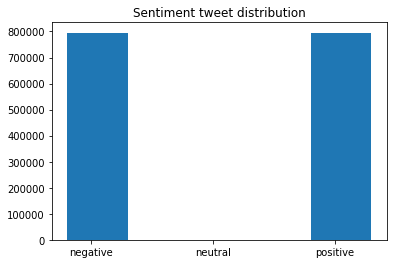

In [0]:
indexes = np.arange(len(sentiment_target))
width = 0.5
plt.bar(indexes, sentiment_tweet_counts, width)
plt.xticks(indexes + width * -0.1, sentiment_target)
plt.title('Sentiment tweet distribution')
plt.show()

In [0]:
count_sentiment_per_term(tweets_data)   
print(Terms_Frequency_Per_Sentiment_Dict)

{0: {'go': 45562, 'work': 45419, 'day': 41373, 'like': 41050, 'today': 38115, 'going': 33688, 'got': 33407, 'back': 33090, 'really': 31496, 'miss': 30712, 'im': 30571, 'want': 29871, 'still': 29261, 'good': 29208, 'sad': 27911, 'time': 27526, 'one': 27261, 'know': 26322, 'home': 24517, 'u': 24055}, 2: {}, 4: {'good': 62110, 'day': 48186, 'love': 47691, 'like': 37520, 'lol': 36106, 'thanks': 34358, 'u': 32058, 'going': 30939, 'time': 30430, 'today': 30100, 'go': 28263, 'got': 28034, 'new': 26939, 'one': 26680, 'see': 25811, 'know': 25747, 'great': 25307, 'back': 23868, 'night': 23722, 'well': 23266}}


In [0]:
sentiment_dict = {
  "negative": 0,
  "neutral": 2,
  "positive": 4
}

for sentiment_name in sentiment_dict:
  print_table_by_sentiment(sentiment_name,sentiment_dict[sentiment_name])
  # print_plot_for_terms_distribution(sentiment_name, sentiment_dict[sentiment_name])

_____________________________________
Top 20 terms for sentiment : negative
_____________________________________
      Term  Term frequency
0       go           45562
1     work           45419
2      day           41373
3     like           41050
4    today           38115
5    going           33688
6      got           33407
7     back           33090
8   really           31496
9     miss           30712
10      im           30571
11    want           29871
12   still           29261
13    good           29208
14     sad           27911
15    time           27526
16     one           27261
17    know           26322
18    home           24517
_____________________________________
Top 20 terms for sentiment : neutral
_____________________________________
There are no tweets with this sentiment value
_____________________________________
Top 20 terms for sentiment : positive
_____________________________________
      Term  Term frequency
0     good           62110
1      day         

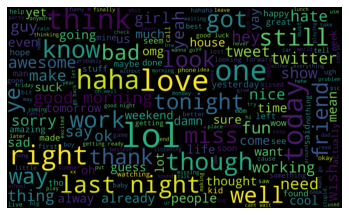

In [0]:
# Word cloud
allWords = []
for twt in tweets_data['text']:
  allWords += twt.split(' ')

allWords = ' '.join(allWords)
wordCloud = WordCloud(width=5000, height=3000, random_state = 21, max_font_size = 500).generate(allWords)

plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

**Sentiment percentage**

In [0]:
sentiments = tweets_data['target'].values
sentiment_sizes = [count_sentiments(sentiments,0), count_sentiments(sentiments,2),count_sentiments(sentiments,4)]

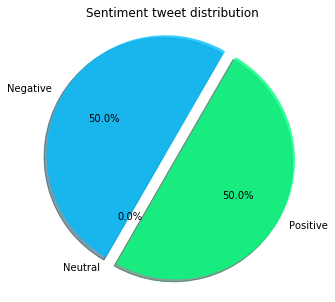

In [0]:
plot_sentiment_pie(sentiment_sizes)

**Top terms frequency**

Term        Frequency
--------  -----------
good            91318
day             89559
like            78570
go              73825
today           68215
work            64947
love            64679
going           64627
got             61441
lol             59226
time            57956
back            56958
one             53941
know            52069
im              50493
really          50020
see             46371
night           43942
still           43560
well            42737
new             42447
want            42300
think           41407
home            40436
thanks          40123
oh              39677
much            37048
miss            36388
need            35986
last            35732
morning         34601
tomorrow        34118
hope            33864
great           33504
twitter         32746
haha            31493
feel            30268
sad             29421
fun             28693
wish            28270


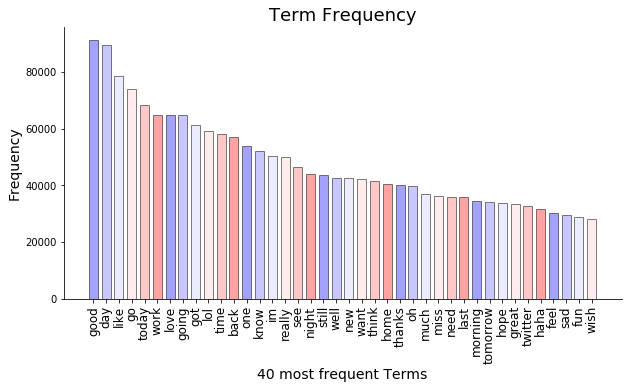

In [0]:
frequency_df = get_frequency_df(tweets_data)

print(tabulate(frequency_df[:TOP_NUMBER],headers=('Term','Frequency'), showindex=False))
graph(frequency_df)

## Question 2

### Train a machine learning model to predict the sentiment 

Partial data to get the right hyper params

In [0]:
records_per_category = 100000
tweets_data_part = tweets_data[:records_per_category]
tweets_data_part = tweets_data_part.append(tweets_data[-records_per_category:])
train_x_partData = tweets_data_part['text'].tolist()
train_y_partData = tweets_data_part['target'].tolist()

print("Num of records for training:", len(train_x_partData))

Num of records for training: 200000


### First simple model

In [0]:
class BestModel:
  
  name = 'Empty'
  score = 0


bestModel = BestModel()
bestConfigs = {}


def updateConfigs(name, vectorizer, classifier, score):
  bestConfigs[name] = {'name': name,'vectorizer': vectorizer, 'classifier': classifier, 'score': score}
  if(score > bestModel.score):
    print('** Found a better model:', name, '**')
    print('\t Score:   %0.3f' % score)
    bestModel.name = name
    bestModel.score = score
  print('Updated:', name)

Tune parameters to find best hyperparams

In [0]:
def tuneParams(estimator, params):
  gridSearch = GridSearchCV(estimator, params, n_jobs=1)
  gridSearch = gridSearch.fit(train_x_partData, train_y_partData)
  print('Best score: ',gridSearch.best_score_)
  print('Best params: ',gridSearch.best_params_)
  return gridSearch.best_params_ , gridSearch.best_score_

In [0]:
params_ranges = {'vect__max_df': np.arange(0.3, 0.81, 0.1),'clf__alpha': np.arange(0.01,0.52,0.2)}

In [0]:
# NB with Tf-idf
parameters = params_ranges
classifier = MultinomialNB()
vectorizer = TfidfVectorizer()
estimator = Pipeline([('vect', vectorizer),('clf', classifier)])

# Fit using Grid Search CV
best , score = tuneParams(estimator, parameters)
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df= best['vect__max_df'], stop_words='english')
classifier = MultinomialNB(alpha= best['clf__alpha'])
updateConfigs('NaiveBayes with TF-idf' , vectorizer, classifier, score)

Best score:  0.74766
Best params:  {'clf__alpha': 0.41000000000000003, 'vect__max_df': 0.3}
** Found a better model: NaiveBayes with TF-idf **
	 Score:   0.748
Updated: NaiveBayes with TF-idf


### LSTM model

Code snipets from https://www.kaggle.com/ngyptr/lstm-sentiment-analysis-keras



Set tokenizer for lstm

In [0]:
max_fatures = 1500
lstm_tokenizer = Tokenizer(num_words=max_fatures, split=' ')
lstm_tokenizer.fit_on_texts(tweets_data_part['text'].values)

Set Train values for model validation

In [0]:
X_train_partData = lstm_tokenizer.texts_to_sequences(tweets_data_part['text'].values)
X_train_partData = pad_sequences(X_train_partData)

Y_train_partData = pd.get_dummies(tweets_data_part['target']).values

In [0]:
def buildLSTMModel():
  max_fatures = 1500
  embed_dim = 128
  lstm_out = 196
  

  # Build model
  model = Sequential()
  model.name = "My LSTM model"
  model.add(Embedding(max_fatures, embed_dim,input_length = x_train_shape_1, name="Embedding_layer"))
  model.add(Dropout(0.5, name="Dropout_0.5"))
  model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2, name="LSTM_layer"))
  model.add(Dense(2, name='Dense_Sigmoid', activation='sigmoid'))
  model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
  return model

### Use GridSearchCV 

Tune parameters to find best hyperparams

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection  import GridSearchCV,RandomizedSearchCV

x_train_shape_1 = X_train_partData.shape[1]

In [0]:
model = KerasClassifier(build_fn=buildLSTMModel,verbose=1)

parameters = {'epochs':[6,7,8], 'batch_size':[800,1000,1200]}

grid_search = GridSearchCV(model, parameters, verbose=1, cv=5)
grid_result = grid_search.fit(X_train_partData, Y_train_partData)


best_lstm_model = grid_search.best_estimator_
best_lstm_params = grid_search.best_params_
best_lstm_history = grid_result.best_estimator_.model.model.history.history

print("\n\n -----------     Best: params using %s    -----------" % (grid_search.best_params_))
print("Best score = %.2f" % max(best_lstm_history['acc']))


### Evaluate two models with best parameters

In [0]:
tweets_data_full = tweets_data
train_x_fullData = tweets_data_full['text'].tolist()
train_y_fullData = tweets_data_full['target'].tolist()

#### Simple model

In [0]:
def extractFeatures(vectorizer, Docs, transform = True):
  if( transform ):
    X = vectorizer.fit_transform(Docs)
  else:
    X = vectorizer.transform(Docs)
  return X

def fitClassifier(clf, X_train, y_train):
    print('_' * 80)
    clf.fit(X_train, y_train)
    return clf

In [0]:
accuracyTable = {}


def runPipelineFromBestConfigTable(key):
  item = bestConfigs[key]
  print('\n\n')
  print('=' * 80)
  print('\t' * 3,item['name'])
  print('\t' * 3,'  With score: %0.3f' % item['score'])
  print('=' * 80)
  vectorizer = item['vectorizer']
  classifier = item['classifier']

  print('\t'*2, '<< Running with best params from tunning >>')
  print('\t'*3, '  Max_df =   %0.3f' % vectorizer.max_df)
  print('\t'*3, '  Alpha  =   %0.3f' % classifier.alpha)


  # Extract features
  print('Extracting')
  X_train = extractFeatures( vectorizer, train_x_fullData)
  print('\tNum of samples in train:', X_train.shape[0])
  print('\tNum of features:', X_train.shape[1])

  clf = fitClassifier(classifier, X_train, train_y_fullData)
  return clf
  

best_simple_model = runPipelineFromBestConfigTable(bestModel.name)




			 NaiveBayes with TF-idf
			   With score: 0.748
		 << Running with best params from tunning >>
			   Max_df =   0.300
			   Alpha  =   0.410
Extracting
	Num of samples in train: 1589715
	Num of features: 264534
________________________________________________________________________________


#### LSTM model

In [0]:
X_train_fullData = lstm_tokenizer.texts_to_sequences(tweets_data_full['text'].values)
X_train_fullData = pad_sequences(X_train_fullData)

Y_train_fullData = pd.get_dummies(tweets_data_full['target']).values

Model: "My LSTM model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_layer (Embedding)  (None, 29, 128)           192000    
_________________________________________________________________
Dropout_0.5 (Dropout)        (None, 29, 128)           0         
_________________________________________________________________
LSTM_layer (LSTM)            (None, 196)               254800    
_________________________________________________________________
Dense_Sigmoid (Dense)        (None, 2)                 394       
Total params: 447,194
Trainable params: 447,194
Non-trainable params: 0
_________________________________________________________________
None

Best params:  {'batch_size': 1000, 'epochs': 8}
Train on 1430743 samples, validate on 158972 samples
Epoch 1/8
1430743/1430743 [==============================] - 85s 59us/step - loss: 0.5058 - acc: 0.7459 - val_loss: 0.5906 - val_acc: 0.70

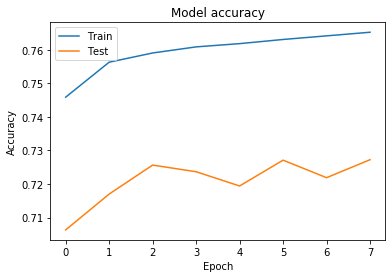

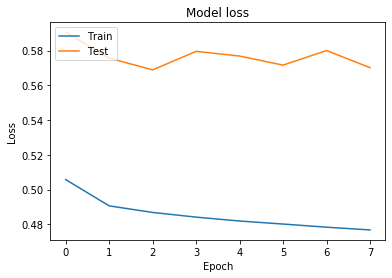

Saved model to disk


In [0]:
# Update the model's input_dim shape
x_train_shape_1 = X_train_fullData.shape[1]

lstm_model = buildLSTMModel()
print(lstm_model.summary())

# for testing
best_lstm_params = {"batch_size": 1000, "epochs": 8}


print("\nBest params: ",best_lstm_params)

lstm_history = lstm_model.fit(X_train_fullData, Y_train_fullData, best_lstm_params['batch_size'], best_lstm_params['epochs'],validation_split = 0.1)
lstm_history = lstm_history.history


print("\n\n ---   Done traning the model    ---")





def getScore(vector):
  # Last score
  return vector[-1]
  # Best score
  # return max(vector)

accuracy = getScore(lstm_history['acc'])
loss = getScore(lstm_history['loss'])

val_accuracy = getScore(lstm_history['val_acc'])
val_loss = getScore(lstm_history['val_loss'])



print("\n\n-----------    Training score    -----------")
print("Accuracy = %.2f" % accuracy)
print("Loss = %.2f" % loss)

print("\n\n-----------    Validation score    -----------")
print("Validation Accuracy = %.2f" % val_accuracy)
print("Validation Loss = %.2f" % val_loss)


# summarize history for accuracy
plt.plot(lstm_history['acc'])
plt.plot(lstm_history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(lstm_history['loss'])
plt.plot(lstm_history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



model_name = 'lstm_model'

model_to_save = lstm_model

# serialize model to YAML
model_yaml = model_to_save.to_yaml()
with open(model_name + ".yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model_to_save.save_weights(model_name + ".h5")
print("Saved model to disk")

Present Train and Test accuracy for the different models and pre-processing combinations

## Save and load LSTM model

In [0]:
model_name = 'lstm_model'

Save

In [0]:
model_to_save = lstm_model

# serialize model to YAML
model_yaml = model_to_save.to_yaml()
with open(model_name + ".yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model_to_save.save_weights(model_name + ".h5")
print("Saved model to disk")

Saved model to disk


Load

In [0]:
from keras.models import model_from_yaml

# load YAML and create model
yaml_file = open(model_name + '.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights(model_name + ".h5")
print("Loaded model from disk")


lstm_model = loaded_model

Loaded model from disk


## Question 3

### Upload the test data

In [0]:
api_training_file_name = "savedTweets-15K-just_text.csv"

api_df = pd.read_csv(api_training_file_name, usecols=['text'], encoding = "utf-8")
api_df

,text
0,@Biggie_Smallz8 @MooreKyle13 Dont do the crime...
1,RT @PrizelessStar: Catch me Live supporting Te...
2,It’s time to get rid of reclining seats in eco...
3,I just got result 'Sasara Nurude' on quiz 'Wha...
4,RT @PleaseBeGneiss: Me: I can’t afford rent\n\...
...,...
14995,@SamsungIndia Ok but what's the thing that you...
14996,RT @qazizaid89: To show doctors outside kashmi...
14997,This piece is finally finished! You'll have to...
14998,RT @NIHRCRN_tvsm: In Oxford today? Our exhibit...


### **pre-processing**

As we did at the first part of the project, we chose to remove all tweets that contain 5 characters or less, but we have found that there are no tweets suit this condition at this dataset.

In [0]:
word_tokenizer = WordPunctTokenizer() 

clean_tweets_api = api_df['text'].apply(lambda x:tweet_cleaning(x,word_tokenizer))

api_df['text'] = clean_tweets_api


api_df

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://t.co/EXgcgcO1Rm" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://t.co/UPOMWL5Wy5" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


,text
0,dont crime bro year olds house arrest spray pa...
1,catch live supporting teni make sure tickets l...
2,time rid reclining seats economy says also cal...
3,got result sasara nurude quiz hypmic character
4,afford rent america good job want college degr...
...,...
14995,ok thing plus
14996,show doctors outside kashmir reports sister di...
14997,piece finally finished come see person color v...
14998,oxford today exhibition nhs research open day ...


We have used ‘TextBlob’ library to labeled the collected tweets’ sentiment. 
‘TextBlob’ provides a consistent API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, and more. The sentiment property returns a named tuple of the form Sentiment (polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.<br>
The mapping we did in order to get tweets; sentiment is:<br>
a.	Negative polarity score (<0) -> NEGATIVE sentiment<br>
b.	Polarity score is zero (=0) -> NEUTRAL sentiment<br>
c.	Positive polarity score (>0) -> POSITIVE sentiment

In [0]:
tweets_data_api = api_df   
from textblob import TextBlob
def get_tweet_sentiment(text): 
  ''' 
  Utility function to classify sentiment of passed tweet 
  using textblob's sentiment method 
  '''
  # create TextBlob object of passed tweet text 
  analysis = TextBlob(text) 
  # set sentiment 
  if analysis.sentiment.polarity > 0: 
      return 4 # 'positive'
  elif analysis.sentiment.polarity == 0: 
      return  2 #'neutral'
  else: 
      return 0 #'negative'

In [0]:
sentiment_dict = {
  "negative": 0,
  "neutral": 2,
  "positive": 4
}
api_sentiments =[]    
for index, row in tweets_data_api.iterrows():
  sentiment = get_tweet_sentiment(row['text'])
  api_sentiments.append(sentiment)
tweets_data_api['target'] = api_sentiments
tweets_data_api

,text,target
0,dont crime bro year olds house arrest spray pa...,0
1,catch live supporting teni make sure tickets l...,4
2,time rid reclining seats economy says also cal...,2
3,got result sasara nurude quiz hypmic character,2
4,afford rent america good job want college degr...,4
...,...,...
14995,ok thing plus,4
14996,show doctors outside kashmir reports sister di...,0
14997,piece finally finished come see person color v...,4
14998,oxford today exhibition nhs research open day ...,2


In [0]:
negative_tweets = class_distribution(tweets_data_api, sentiment_dict["negative"])   
neutral_tweets = class_distribution(tweets_data_api, sentiment_dict["neutral"])
positive_tweets = class_distribution(tweets_data_api, sentiment_dict["positive"])

sentiment_tweet_counts = [negative_tweets,neutral_tweets,positive_tweets]

print("Amount of negative tweets: " + str(negative_tweets))
print("Amount of neutral tweets: " + str(neutral_tweets))
print("Amount of positive tweets: " + str(positive_tweets))

Amount of negative tweets: 3334
Amount of neutral tweets: 5839
Amount of positive tweets: 5827


**Class distribution - by plot**

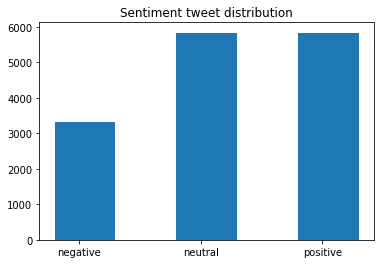

In [0]:
sentiment_target = ['negative', 'neutral','positive']
indexes = np.arange(len(sentiment_target))
width = 0.5
plt.bar(indexes, sentiment_tweet_counts, width)
plt.xticks(indexes + width * -0.1, sentiment_target)
plt.title('Sentiment tweet distribution')
plt.show()

In [0]:
count_sentiment_per_term(tweets_data_api)   
print(Terms_Frequency_Per_Sentiment_Dict)

{0: {'someone': 344, 'time': 340, 'like': 303, 'man': 268, 'block': 265, 'tell': 261, 'leave': 256, 'dressed': 250, 'dog': 243, 'everytime': 242, 'tries': 239, 'plz': 234, 'people': 230, 'shit': 190, 'mean': 150, 'know': 149, 'trump': 149, 'fucking': 141, 'stupid': 136, 'give': 127}, 2: {'like': 369, 'people': 359, 'spanish': 292, 'help': 290, 'work': 282, 'man': 258, 'let': 248, 'know': 229, 'one': 220, 'anyone': 209, 'want': 206, 'things': 205, 'speak': 204, 'change': 199, 'done': 196, 'alone': 189, 'hour': 185, 'double': 181, 'unskilled': 178, 'alzheimer': 178}, 4: {'like': 461, 'people': 396, 'let': 372, 'love': 351, 'ready': 339, 'time': 324, 'good': 307, 'one': 288, 'know': 284, 'new': 282, 'trump': 275, 'much': 264, 'never': 255, 'really': 249, 'better': 240, 'right': 238, 'see': 223, 'want': 197, 'free': 185, 'first': 180}}


### Analyze the most popular terms for each sentiment

In [0]:
for sentiment_name in sentiment_dict:
  print_table_by_sentiment(sentiment_name,sentiment_dict[sentiment_name])

_____________________________________
Top 20 terms for sentiment : negative
_____________________________________
         Term  Term frequency
0     someone             344
1        time             340
2        like             303
3         man             268
4       block             265
5        tell             261
6       leave             256
7     dressed             250
8         dog             243
9   everytime             242
10      tries             239
11        plz             234
12     people             230
13       shit             190
14       mean             150
15       know             149
16      trump             149
17    fucking             141
18     stupid             136
19       give             127
_____________________________________
Top 20 terms for sentiment : neutral
_____________________________________
         Term  Term frequency
0        like             369
1      people             359
2     spanish             292
3        help          

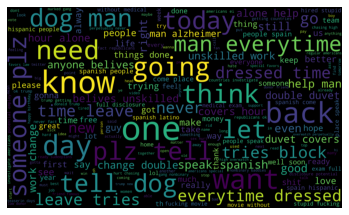

In [0]:
allWords = []
for twt in tweets_data_api['text']:
  allWords += twt.split(' ')

allWords = ' '.join(allWords)
wordCloud = WordCloud(width=5000, height=3000, random_state = 21, max_font_size = 500).generate(allWords)

plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

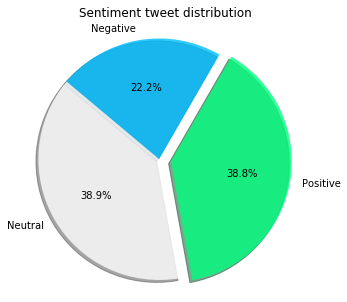

In [0]:
sentiments_api = tweets_data_api['target'].values
sentiment_api_sizes = [count_sentiments(sentiments_api,0), count_sentiments(sentiments_api,2),count_sentiments(sentiments_api,4)]
plot_sentiment_pie(sentiment_api_sizes)

### Present terms frequency and discuss the similarity with the train

Term       Frequency
-------  -----------
like            1133
people           985
time             828
let              679
know             662
one              615
man              612
trump            523
someone          491
want             475
work             473
help             464
never            453
go               413
see              409
things           407
need             386
please           382
love             375
back             374
day              364
tell             360
ready            360
think            340
would            338
good             331
come             327
much             324
way              324
well             321
going            319
us               313
really           312
new              309
anyone           305
still            302
done             299
leave            299
say              297
spanish          293


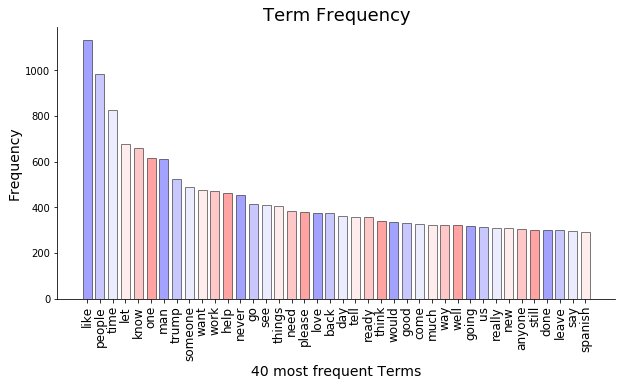

In [0]:
from tabulate import tabulate
from sklearn.feature_extraction.text import CountVectorizer
frequency_df = get_frequency_df(tweets_data_api)

print(tabulate(frequency_df[:TOP_NUMBER],headers=('Term','Frequency'), showindex=False))
graph(frequency_df)

## Question 4

Test values from collected tweets

In [0]:
x_newTweets = tweets_data_api['text']
y_newTweets = tweets_data_api['target']

print("Collected tweets size = ", len(x_newTweets))

Collected tweets size =  15000


In [0]:
max_fatures = 2000
lstm_tokenizer = Tokenizer(num_words=max_fatures, split=' ')
lstm_tokenizer.fit_on_texts(x_newTweets.values)

### Use the best model from Q2 to predict sentiments of the collected Tweets

In [0]:
# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLD = 0.6

Our model is a binary classifier for Positive and Negative 

In order to get some Natural predictions we set SENTIMENT_THRESHOLD

In [0]:
def decode_sentiment(pos_score, neg_score):
    label = NEUTRAL
    if neg_score >= SENTIMENT_THRESHOLD:
        label = NEGATIVE
    elif pos_score >= SENTIMENT_THRESHOLD:
        label = POSITIVE

    return label     
        
def predict(text, model, maxlen, print_score = False):

    # Tokenize text


    x_pad_test = pad_sequences(lstm_tokenizer.texts_to_sequences([text]), maxlen)
    # Predict
    score = model.predict([x_pad_test])[0]
    
    neg_score = score[0]
    pos_score = score[1]
    
    if(print_score):
      print("Neg =", neg_score, '\t',"Pos =", pos_score)

    # Decode sentiment
    label = decode_sentiment(pos_score,neg_score)

    return label


In [0]:
embedding_output_shape = lstm_model.layers[0].output_shape[1]
print("Embedding output shape = ", embedding_output_shape)
best_model = lstm_model

Embedding output shape =  29


In [0]:
def predictLabel(text, print_score = False):
  return predict(text, lstm_model, embedding_output_shape, print_score)


def check_single_tweet(tweet,  print_score = True):
  print("\n","-"*20)
  tweet_label = predictLabel(tweet, print_score = True)
  print('\n','\"',tweet,'\"', 'sentiment is ', tweet_label)
  print("-"*20, "\n")

Predict Examples

In [0]:
check_single_tweet("I love this song!")
check_single_tweet("I'm scared of spiders")


 --------------------
Neg = 0.061768185 	 Pos = 0.9388439

 " I love this song! " sentiment is  POSITIVE
-------------------- 


 --------------------
Neg = 0.94439465 	 Pos = 0.053977422

 " I scared of spiders " sentiment is  NEGATIVE
-------------------- 



In [0]:
check_single_tweet("dog")
check_single_tweet("great dog")
check_single_tweet("bad dog")


 --------------------
Neg = 0.55408776 	 Pos = 0.4496464

 " dog " sentiment is  NEUTRAL
-------------------- 


 --------------------
Neg = 0.2011267 	 Pos = 0.8036854

 " great dog " sentiment is  POSITIVE
-------------------- 


 --------------------
Neg = 0.925542 	 Pos = 0.07642099

 " bad dog " sentiment is  NEGATIVE
-------------------- 



Predict all tweets

In [0]:
def checkPrediction(expected, actual):
  
  if(expected == 0):
    expected = NEGATIVE
  elif(expected == 2):
    expected == NEUTRAL
  elif(expected == 4):
    expected = POSITIVE
  
  if(expected == actual):
    return True
  
  return False


def predict_all_with_lstm(x_test, y_test, print_text_lable = False):

  test_size = len(x_test)
  correctPrediction = 0
  wrong_prediction = 0

  for i in range(0,test_size):

    if(x_test[i] == ""):
      continue
    
    expected = y_test[i]
    actual = predictLabel(x_test[i])

    if(print_text_lable):
      print(i, '-','\"'+ x_test[i] + '\"', "Sentimnet is", actual)

    if(checkPrediction(expected, actual)):
      correctPrediction += 1
    else:
      wrong_prediction += 1
  
  print('\n')
  # print("Correct predication = ", correctPrediction)
  # print("Wrong predication = ", wrong_prediction)

  accuracy = correctPrediction/test_size
  return accuracy * 100



In [0]:

def predictWithLSTM(lstm_params, lstm_model, model_history, x_to_predict, y_to_predict):

  batch_size = lstm_params["batch_size"]
  epochs = lstm_params["epochs"]

  print('=' * 80)
  print('\t' * 3,"My LSTM Model", "(acc = %.2f)" % lstm_history['acc'][-1])
  print('=' * 80)

  print('\t'*2, '<< Running with best params from tunning >>')

  print('\t'*3, '  Batch size =   %d' % batch_size)
  print('\t'*3, '  Epochs  =   %d' % epochs)

  accuracy = predict_all_with_lstm(x_to_predict, y_to_predict)

  return accuracy

In [0]:
num_of_tweets_to_predict = 15000

x_to_predict = x_newTweets[:num_of_tweets_to_predict]
y_to_predict = y_newTweets[:num_of_tweets_to_predict]

In [0]:

best_params = best_lstm_params
best_model = lstm_model
model_history = lstm_history



accuracy = predictWithLSTM(best_params, best_model, model_history, x_to_predict, y_to_predict)

print('=' * 80)
# print('\t' * 2,"Test prediction:", "Accuracy = %.2f" % accuracy)
print('=' * 80)


			 My LSTM Model (acc = 0.77)
		 << Running with best params from tunning >>
			   Batch size =   1000
			   Epochs  =   8


Correct predication =  335
Wrong predication =  649
		 Test prediction: Accuracy = 33.50


### Present the prediction results and your conclusions

In [0]:
# print tweet and sentiment
accuracy = predict_all_with_lstm(x_to_predict, y_to_predict, True)

Streaming output truncated to the last 5000 lines.
9935 - "paying fair share taxes rich want pay fair share taxes rich" Sentimnet is NEGATIVE
9936 - "regret rain nights felt pain tears cry times along way" Sentimnet is NEGATIVE
9937 - "least popular girl powers yes" Sentimnet is POSITIVE
9938 - "sorry jealous nonsense reasons" Sentimnet is NEGATIVE
9939 - "take steroids still barely scratch pitch" Sentimnet is NEGATIVE
9940 - "little situation lady got shot killed exposing trying money dl man" Sentimnet is NEGATIVE
9941 - "anyone belives unskilled work change double duvet covers hour alone help man alzheimer" Sentimnet is NEGATIVE
9942 - "love butterfly feeling suddenly see blue" Sentimnet is POSITIVE
9943 - "lets along" Sentimnet is POSITIVE
9944 - "come sweaty back" Sentimnet is NEUTRAL
9945 - "enough recognition swear" Sentimnet is NEGATIVE
9946 - "trump new pardons mostly aimed wiping clean slates rich powerful well connected white men come" Sentimnet is POSITIVE
9947 - "liverpool 